In [ ]:
# !pip install -U yt-dlp==2023.1.6 matplotlib==3.6.0 datasets[audio] rich

# install newest transformers build to be able to pass `inputs_embeds` through generate()
# !pip install --upgrade git+https://github.com/huggingface/transformers.git

**Relevant huggingface gpt2 code**

- https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py
- https://github.com/huggingface/transformers/issues/6535
- bos/eos discussion: https://github.com/huggingface/transformers/issues/3311

**Todo**

- Rerun embedding generation for musiccaps/make sure it's the same as jamendo and none of the changes in mtg_jam.. broke it (forward hook should use input or output correctly)
- embedding concat vs sum vs mean
- metrics (with different generation methods/args)
- tokenization might still be a problem

# Load musiccaps

In [1]:
from musiccaps import load_musiccaps
import numpy as np
from rich import print as printr
from torch.utils.data import DataLoader, Dataset, random_split
import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import itertools
import math
from rich import print as printr
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from pathlib import Path
import json
import random
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def filter_muscaps_with_embeddings(ds, embeddings):
    '''Some clips weren't downloaded so we couldn't embed them, get rid of that'''
    exclude_ids = set()
    for i in range(len(ds)):
        if ds[i]['ytid'] not in embeddings.keys():
            exclude_ids.add(i)
    ds = ds.select(
        (
            i for i in range(len(ds)) 
            if i not in set(exclude_ids)
        )
    )
    assert len(ds) == len(embeddings)
    return ds

In [3]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True
)
embeddings = np.load('embeddings.npy', allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


In [4]:
class CaptionEmbedding(Dataset):
    '''Returns a torch Dataset of paired captions and embeddings'''
    def __init__(self, muscaps_ds, embeddings):
        ds = filter_muscaps_with_embeddings(muscaps_ds, embeddings)
        self.captions = ds.sort(column='ytid')['caption']
        sorted_embs = [value for _, value in sorted(embeddings.items())]
        self.embeddings = torch.from_numpy(np.stack(sorted_embs)).to(device)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        
        emb = self.embeddings[idx]
        assert len(emb) == 512
        emb = (emb[:256]+emb[256:])/2
        
        return self.captions[idx], emb

In [5]:
dataset = CaptionEmbedding(muscaps_ds=ds, embeddings=embeddings)
train_frac = 0.8
training_data, test_data = random_split(dataset, [train_frac, 1-train_frac])

# quick check did not mess up ordering of caption-embedding pairs
# for cap, emb in tqdm(dataset):
#     for i in range(len(ds)):
#         if cap == ds[i]['caption']:
#             assert torch.allclose(emb,torch.from_numpy(embeddings[ds[i]['ytid']]).to(device))

Parameter 'indices'=<generator object filter_muscaps_with_embeddings.<locals>.<genexpr> at 0x7f97e75793c0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
# get a list of music-related words to use for evaluation
aspects = []
for x in ds:
    aspect_str = x['aspect_list']
    for t in ('[]"\''):
        aspect_str = aspect_str.replace(t, '')
    aspects.extend(aspect_str.split(', '))
    
from collections import Counter
# only pick aspects that show up somewhat frequently
aspects = {s for s, count in Counter(aspects).most_common() if count >= 25}
len(aspects)

378

# Load Jamendo tag/embedding dataset

In [7]:
JAMENDO_TAGS = np.array(['genre---alternative','genre---ambient','genre---atmospheric','genre---chillout','genre---classical','genre---dance','genre---downtempo','genre---easylistening','genre---electronic','genre---experimental','genre---folk','genre---funk','genre---hiphop','genre---house','genre---indie','genre---instrumentalpop','genre---jazz','genre---lounge','genre---metal','genre---newage','genre---orchestral','genre---pop','genre---popfolk','genre---poprock','genre---reggae','genre---rock','genre---soundtrack','genre---techno','genre---trance','genre---triphop','genre---world','instrument---acousticguitar','instrument---bass','instrument---computer','instrument---drummachine','instrument---drums','instrument---electricguitar','instrument---electricpiano','instrument---guitar','instrument---keyboard','instrument---piano','instrument---strings','instrument---synthesizer','instrument---violin','instrument---voice','mood/theme---emotional','mood/theme---energetic','mood/theme---film','mood/theme---happy','mood/theme---relaxing'])

def get_top_tags(scores, k=3, threshold=.4):
    assert scores.shape == (2, 50)
    scores = (scores[0]+scores[1])/2
    indices = np.where(scores>threshold)[0]
    sorted_indices = indices[np.argsort(-scores[indices])[:k]]
    return JAMENDO_TAGS[sorted_indices]

In [8]:
jam_tags = {}
jam_pred_tags = {}
jam_embeddings = {}
jam_scores = {}

jam_embeddings_dir = Path('./jam_embeddings')

for i in range(100):
    try:
        with open(jam_embeddings_dir / f'tags_{i:02d}.json') as f:
            jam_tags.update(json.load(f))
    except Exception as e:
        print(e)
        continue
    data_dict = np.load(jam_embeddings_dir / f'embeddings_{i:02d}.npy', allow_pickle=True)
    jam_embeddings.update(data_dict.item())
    data_dict = np.load(jam_embeddings_dir / f'tag_scores_{i:02d}.npy', allow_pickle=True)
    jam_scores.update(data_dict.item())
    
for k, v in jam_scores.items():
    jam_pred_tags[k] = get_top_tags(v, k=3, threshold=0.4)
    
pred_tag_counts = np.array([len(v) for v in jam_pred_tags.values()])
print(f'avg number of pred tags = {(pred_tag_counts).mean()}, fraction of samples with 0 pred tags = {(pred_tag_counts==0).mean()}')

[Errno 2] No such file or directory: 'jam_embeddings/tags_35.json'
avg number of pred tags = 1.1215934627170583, fraction of samples with 0 pred tags = 0.21151453245426688


In [9]:
pred_tag_counts = np.array([len(v) for v in jam_tags.values()])
print(f'avg number of jamendo tags = {(pred_tag_counts).mean()}, fraction of samples with 0 jamendo tags = {(pred_tag_counts==0).mean()}')

avg number of jamendo tags = 4.659095552047543, fraction of samples with 0 jamendo tags = 0.0


In [10]:
for x in list(jam_tags.keys())[:15]:
    print(jam_tags[x])
    print(jam_pred_tags[x])
    print()

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock' 'instrument---drums']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock' 'instrument---drums' 'instrument---bass']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---electronic']
['genre---electronic' 'genre---dance']

['genre---electronic']
['genre---electronic']

In [70]:
jam_shuffle_order = False

In [74]:
class JamendoTagDataset(Dataset):
    def __init__(self, jam_tags, jam_pred_tags, jam_embeddings):
        
        self.keys = sorted(jam_tags.keys())
        self.jam_tags = jam_tags
        self.jam_pred_tags = jam_pred_tags
        self.jam_embeddings = jam_embeddings

    def __len__(self):
        return len(self.jam_tags)

    def __getitem__(self, idx):
        id = self.keys[idx]
        
        tags = self.jam_tags[id]
        categories = defaultdict(set)
        for t in tags:
            assert '---' in t
            categories[t[:t.find('---')]].add(t[t.find('---')+3:])
            
        result = []
        for k in sorted(categories.keys()):
            cat_tags = list(categories[k])
            
            if jam_shuffle_order:
                ts = random.sample(cat_tags, len(cat_tags))
            else:
                ts = sorted(cat_tags)
            result.append(k + ': ' + ', '.join(ts))
        tags_cap = '; '.join(result)
            
        #tags = [t.replace('---', ': ') for t in tags]
        #tags = [t[t.find('---')+3:] if '---' in t else t for t in tags]
        #random.shuffle(tags)
        #tags_cap = ', '.join(tags)
        
        emb = self.jam_embeddings[id]
        assert emb.shape == (2, 256)
        emb = (emb[0]+emb[1])/2
        
        return tags_cap, torch.from_numpy(emb).to(device)

In [75]:
jam_dataset = JamendoTagDataset(jam_tags, jam_pred_tags, jam_embeddings)
train_frac = 0.9
training_data, test_data = random_split(jam_dataset, [train_frac, 1-train_frac])

# Image Captioning

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
encoder_forward = model.encoder.forward

In [ ]:
EMBS = torch.zeros(1, 1, 768).to(device)

In [ ]:
def patched_forward(*args, **kwargs):
    result = encoder_forward(*args, **kwargs) # this is just to appease the HuggingFace gods
    result.last_hidden_state = (EMBS).repeat(1, 197, 1) # overwrite with actual embedding we use
    return result

# the original model uses a vision transformer in the encoder forward, so we get rid of that 
# and use the embeddings we have for the music

model.encoder.forward = patched_forward

In [ ]:
model.forward(torch.zeros(1, 3, 224, 224).to(device), labels=torch.zeros(1, 1).long().to(device))

# Training

### Tokenization

target should be:

`"<pad> caption <eos> <mask...>"` (first element is dropped in transformer.forward)

input should be:

`"<music-emb> caption <eos> <pad...>"`

where

- `<bos>` = `<eos>` (for gpt2, see https://github.com/huggingface/transformers/issues/2026)
- `<mask>` is -100 (masked in cross-entropy, see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- `<pad>` is arbitrary
- `<music-emb>` is the encoded music

In [22]:
class ResidualLinear(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        
    def forward(self, x):
        return x + self.fc(torch.nn.functional.relu(x))

class B2T(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 768),
        )
        
    def forward(self, x):
        return self.main(x)

In [23]:
def tokenize(captions_batch):
    input_ids = tokenizer(captions_batch)['input_ids']
    
     # wrap in eos and add placeholder for music embedding/mask
    input_ids = [torch.tensor([eos_id, placeholder_id] + x + [eos_id]) for x in input_ids]
    # pad with -100, this index is masked in the cross-entropy loss
    input_ids_target = torch.nn.utils.rnn.pad_sequence(
        input_ids,
        batch_first=True,
        padding_value=mask_id
    ).to(device)
    
    # index -100 isn't valid as model input however, since the token embedding lookup fails
    # so we need a second version as model input, with -100 replaced with another token (shouldn't matter which)
    input_ids = input_ids_target.clone()
    input_ids[input_ids==mask_id] = eos_id
    
    return input_ids, input_ids_target

In [24]:
def transform_input_ids(music_embedding, input_ids, input_ids_target):
    music_emb_ind = 1
    assert (input_ids[:, music_emb_ind]==placeholder_id).all()
    assert (input_ids_target[:, music_emb_ind]==placeholder_id).all()

    input_ids_target[:, music_emb_ind] = tokenizer.vocab['>'] # mask_id
    input_ids[:, music_emb_ind] = eos_id # temp placeholder to make the embedding lookup work
    inputs_embeds = model.transformer.wte(input_ids)
    
    inputs_embeds[:, music_emb_ind] = b2t(music_embedding)
    
    return inputs_embeds, input_ids_target

In [25]:
@torch.no_grad()
def manual_generate_single(inputs_embeds, max_length, do_sample):
    """ Autoregressively generate max_len tokens based on the embedded prompt. """
    result = []
    log_probs = []

    for i in range(max_length):
        logits = model.forward(inputs_embeds=inputs_embeds).logits[:, -1]

        distr = torch.distributions.Categorical(logits=logits)
        token_inds = distr.sample() if do_sample else logits.argmax(-1)
        log_probs.append(distr.log_prob(token_inds))
        
        result.append(token_inds)

        inputs_embeds = torch.cat([
            inputs_embeds,
            model.transformer.wte(token_inds).unsqueeze(1)
        ], dim=1)
        
    log_probs = torch.stack(log_probs, dim=1)
    ppl = 2**(-(1/len(log_probs))*log_probs.sum(-1))
        
    return torch.stack(result, dim=1), ppl

@torch.no_grad()
def manual_generate(inputs_embeds, iters, max_length, do_sample):
    """ Repeatedly generate samples using manual_generate_single and return the ones with the lowest perplexity. """
    preds = []
    ppls = []
    
    for i in range(iters):
        pred, ppl = manual_generate_single(inputs_embeds, max_length, do_sample)
        preds.append(pred)
        ppls.append(ppl)
    
    preds = torch.stack(preds)
    ppls = torch.stack(ppls)
    
    max_ppl_inds = ppls.argmin(0)
    best_preds = preds[max_ppl_inds, np.arange(preds.shape[1])]
    
    return best_preds, ppls.min(0)[0]

In [26]:
def strip_eos(pred):
    pred = [p.removeprefix('<|endoftext|>') for p in pred]
    pred = [p[:p.find('<|endoftext|>')] if '<|endoftext|>' in p else p for p in pred]
    return pred

def eval(caption_batch, embedding_batch, use_manual_generation=False, rm_eos=False, **kwargs):
    model.eval()
    input_ids, input_ids_target = tokenize(caption_batch)
    inputs_embeds, _ = transform_input_ids(
        embedding_batch,
        input_ids,
        input_ids_target
    )
    inputs_embeds = inputs_embeds[:, :2]
    
    if use_manual_generation:
        output_ids, ppl = manual_generate(inputs_embeds, **kwargs)
    else:
        output_ids = model.generate(inputs_embeds=inputs_embeds, **kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
    pred = [p.replace('\n', '').strip() for p in pred]
    return strip_eos(pred) if rm_eos else pred

In [44]:
model_name = 'gpt2' # gpt2, gpt2-medium, gpt2-large, gpt2-xl
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.config.is_decoder = True
tokenizer = AutoTokenizer.from_pretrained(model_name)
b2t = B2T().cuda()

mask_id = -100 # don't change, this is fixed in torch cross-entropy loss!
eos_id = tokenizer.eos_token_id
# bos_id = eos_id
placeholder_id = -200

opt = torch.optim.Adam([
    {'params': b2t.parameters(), 'lr': 0.00025},
    # disable AdamW weight decay for gpt2 layer finetuning!
    #{'params': model.parameters(), 'lr': 0, 'weight_decay': 0},
    {'params': model.transformer.h[1].parameters(), 'lr': 0, 'weight_decay': 0},
    {'params': model.transformer.h[2].parameters(), 'lr': 0, 'weight_decay': 0},
    #{'params': model.transformer.h[3].parameters(), 'lr': 0, 'weight_decay': 0},
])

batch_size = 64
num_epochs = 5000
epoch = 0

losses = []
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
eval_train_dataloader = DataLoader(training_data, 1, shuffle=True)
eval_test_dataloader = DataLoader(test_data, 1, shuffle=True)

todo:
- maybe use bos token at beginning and use attention_mask to mask out hidden states from the very first generated token? but: generate doesn't use attention_mask, which is weird? instead it has a pad_token_id/mask_token_id though? 

In [80]:
generation_params_hf = dict(
    max_new_tokens=64,
    num_beams=4,
    do_sample=True,
    temperature=1.0,
    bos_token_id=eos_id,
    eos_token_id=eos_id,
    pad_token_id=mask_id,
    early_stopping=True,
    
    use_manual_generation=False,
    rm_eos=True,
)

In [81]:
def update_step(inputs_embeds, input_ids_target, apply_grad):
    model.train()
    loss = model.forward(inputs_embeds=inputs_embeds, labels=input_ids_target).loss
    loss.backward()
    
    if apply_grad:
        opt.step()
        opt.zero_grad()
    
    return loss.item()

def eval_step():
    caption_batch, embedding_batch = next(iter(eval_train_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params_hf)
    
    printr('[green bold]TRAIN TRUE: ' + caption_batch[0])
    printr('[blue]TRAIN PRED-HF: ' + pred[0])
    #pred = eval(caption_batch, embedding_batch, **generation_params_ours)
    #printr('[blue]TRAIN PRED-OUR: ' + pred[0])

    caption_batch, embedding_batch = next(iter(eval_test_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params_hf)
    printr('[green bold]TEST TRUE: ' + caption_batch[0])
    printr('[blue]TEST PRED-HF: ' + pred[0])
    #pred = eval(caption_batch, embedding_batch, **generation_params_ours)
    #printr('[blue]TEST PRED-OUR: ' + pred[0])

  0%|          | 0/4967 [00:00<?, ?it/s]

Unfroze gpt2


  0%|          | 0/3786 [00:00<?, ?it/s]

TRAIN TRUE: genre: classical; instrument: piano

TRAIN PRED-HF: genre: classical; instrument: piano

TEST TRUE: genre: dub, electronic, reggae; instrument: bass, drums, electricguitar

TEST PRED-HF: genre: dub, reggae; instrument: bass, drums, electricguitar

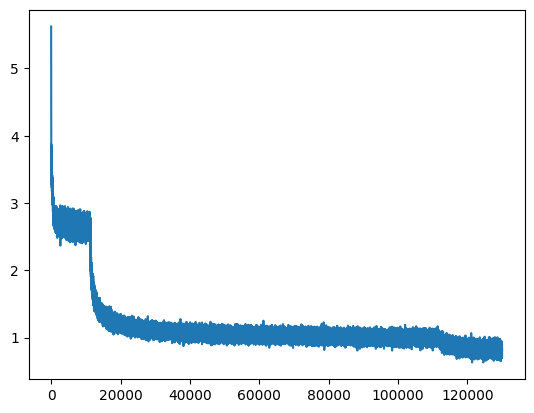

KeyboardInterrupt: 

In [85]:
for epoch in tqdm(range(epoch, num_epochs)):
    
    torch.save({'model': model.state_dict(), 'b2t': b2t.state_dict(), 'opt': opt}, f'./checkpoints/chkp_{epoch}.pt')    
    
    if epoch >= 3:
        print('Unfroze gpt2')
        for pg in opt.param_groups[1:]:
            pg['lr'] = 0.3*5e-5
    
    for step, (caption_batch, embedding_batch) in enumerate(tqdm(train_dataloader)):
        # tokenize and prepare inputs for forward
        input_ids, input_ids_target = tokenize(caption_batch)
        inputs_embeds, input_ids_target = transform_input_ids(
            embedding_batch,
            input_ids,
            input_ids_target
        )
        
        apply_grad_cond = (epoch < 10) or (step%8==0)
        
        losses.append(update_step(inputs_embeds, input_ids_target, apply_grad=apply_grad_cond))
        
        if step % 300 == 0:
            eval_step()
            plt.plot(losses)
            plt.show()

In [87]:
final_eval_test_dataloader = DataLoader(test_data, 1, shuffle=True)
eval_true_captions = []
eval_pred_captions = []

In [88]:
for j in range(1000):
    data_dict = torch.load(f'./checkpoints/chkp_{j}.pt')
    model.load_state_dict(data_dict['model'])
    b2t.load_state_dict(data_dict['b2t'])

    true, preds = [], []
    for i, (caption_batch, embedding_batch) in enumerate(tqdm(final_eval_test_dataloader)):
        pred = eval(caption_batch, embedding_batch, **generation_params_hf)
        true.append(caption_batch[0])
        preds.append(pred[0])
        if i >= 300:
            break
        
    eval_true_captions.append(true)
    eval_pred_captions.append(preds)

  0%|          | 0/26922 [00:00<?, ?it/s]

In [89]:
import evaluate
google_bleu = evaluate.load("google_bleu")

In [64]:
import json

In [66]:
json.dump(dict(
    eval_true_captions=eval_true_captions,
    eval_pred_captions=eval_pred_captions
), open('preds.json', 'w'))

In [90]:
gleu = []


for p, t in zip(eval_pred_captions, eval_true_captions):
    gleu.append(google_bleu.compute(predictions=p, references=t)['google_bleu'])

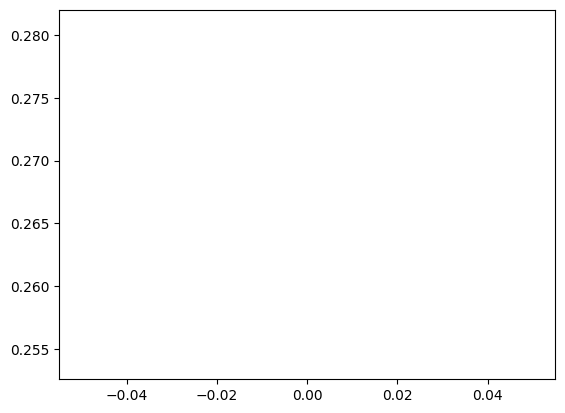

In [91]:
plt.plot(gleu)

**Options**

- different gpt2 sizes
- gpt2 self-att vs gpt-2 cross-att (image captioning)
- which gpt2 layers to finetune
- let b2t output a bunch of 768 dimensional vectors to attend to

In [2]:
import json

In [4]:
preds = json.load(open('preds.json'))

In [ ]:
for i in range(10):
    print('TRUE:', preds['eval_true_captions'][-1][i])
    print('PRED:', preds['eval_pred_captions'][-1][i])    
    print()

TRUE: genre: ambient, soundtrack, classical; instrument: piano
PRED: genre: soundtrack, classical, ambient; instrument: piano

TRUE: genre: pop, popfolk, world; instrument: percussion, acousticguitar, cajon, bass, piano
PRED: genre: folk, popfolk; instrument: ukulele; mood/theme: happy

TRUE: genre: electronic; instrument: piano; mood/theme: film
PRED: genre: classical, soundtrack; instrument: piano; mood/theme: film

TRUE: genre: classical, soundtrack, atmospheric; instrument: organ
PRED: genre: electronic

TRUE: genre: reggae, ska
PRED: genre: reggae

TRUE: genre: rock
PRED: genre: poprock, pop; instrument: electricguitar, bass, drums

TRUE: genre: folk, instrumentalpop
PRED: genre: popfolk, folk; instrument: acousticguitar, ukulele; mood/theme: folkrock

TRUE: genre: electronic, chillout, ambient, easylistening
PRED: genre: techno, minimaltechno; mood/theme: deep

TRUE: genre: hiphop, rap
PRED: genre: electronic

TRUE: genre: experimental, blues; instrument: electricguitar, synthesi